In [13]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time 
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [14]:
device = 'cuda:0'

In [18]:
INPUT_DIR_PATH = 'C:/datasets/m5-forecasting-accuracy/'

In [19]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def read_data():
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    submission_df = pd.read_csv(INPUT_DIR_PATH + 'sample_submission.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df
    

In [20]:
_,  calendar_df, sales_train_validation_df, _ = read_data()

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1919 columns


In [21]:
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [22]:
sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales_train_validation_df['item_store_id'].values

DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


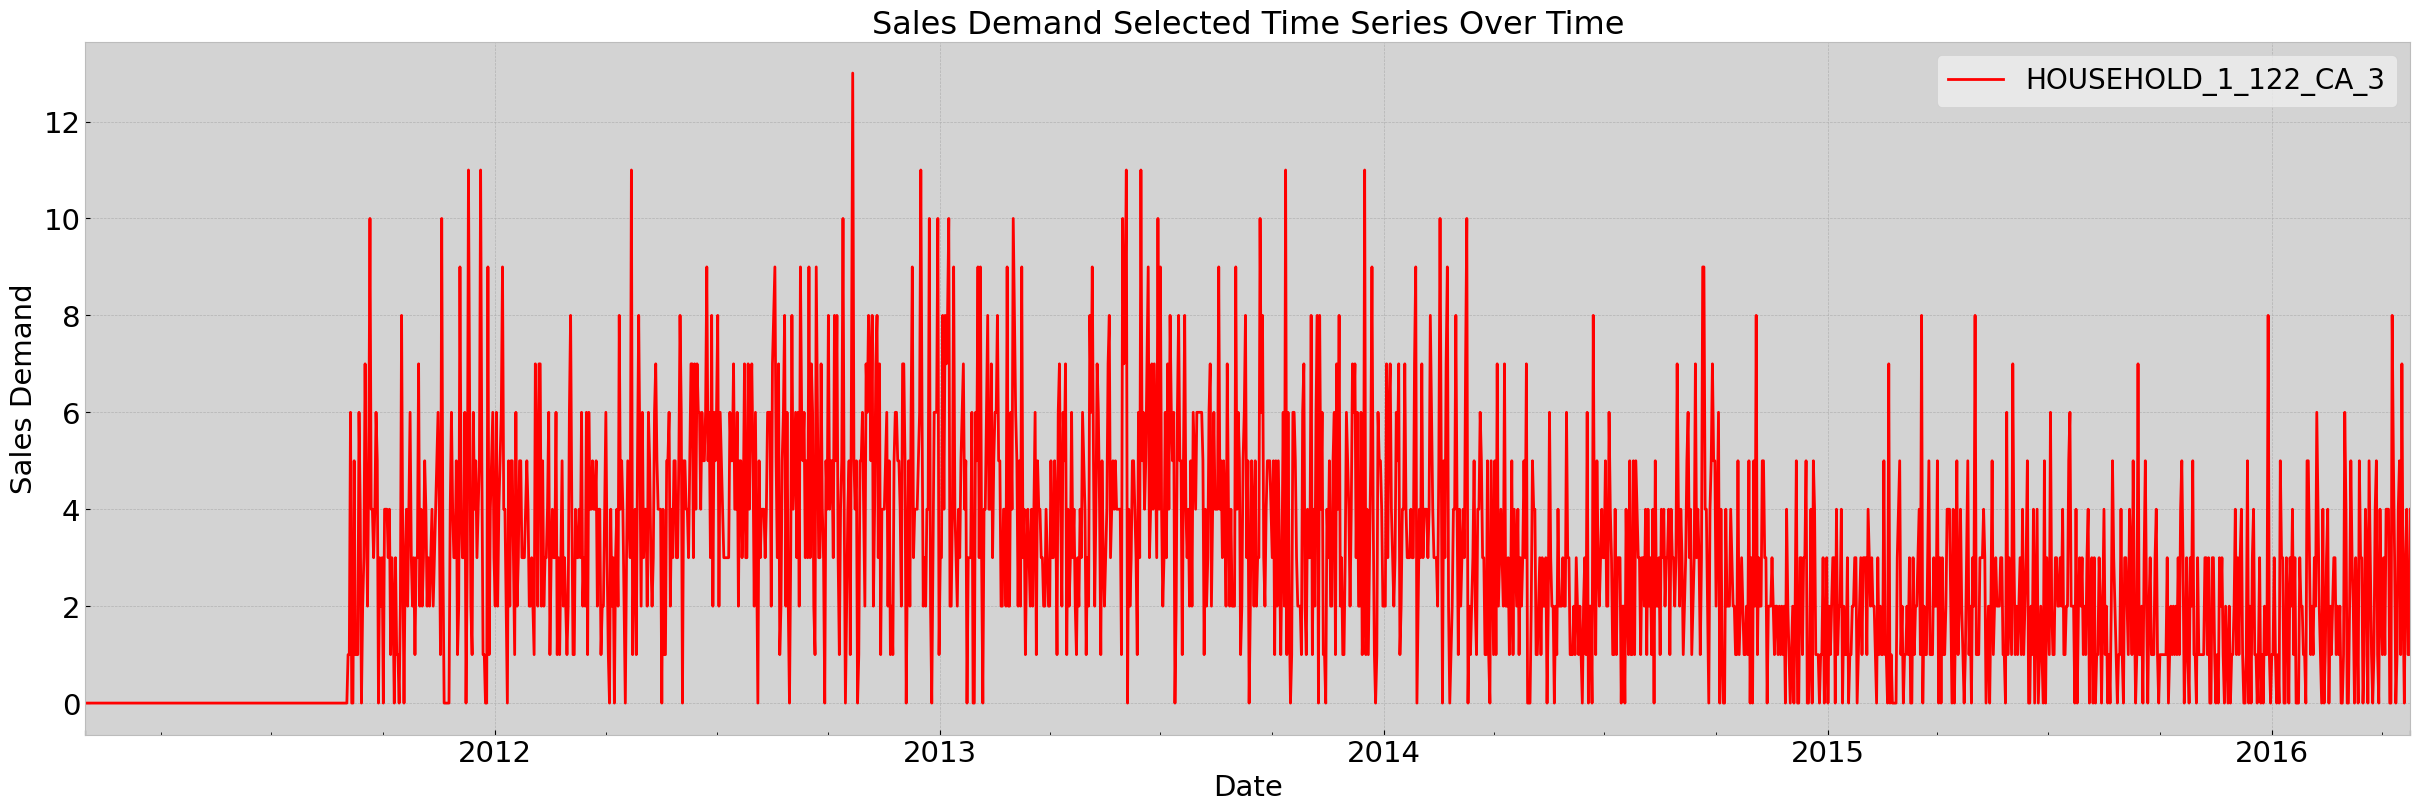

In [23]:
index = 6780
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [26]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

In [27]:
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [28]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
[[-0.53846154]
 [-0.38461538]
 [-0.84615385]
 [-0.84615385]
 [-0.38461538]]


<AxesSubplot:title={'center':' After Normalization'}, ylabel='Frequency'>

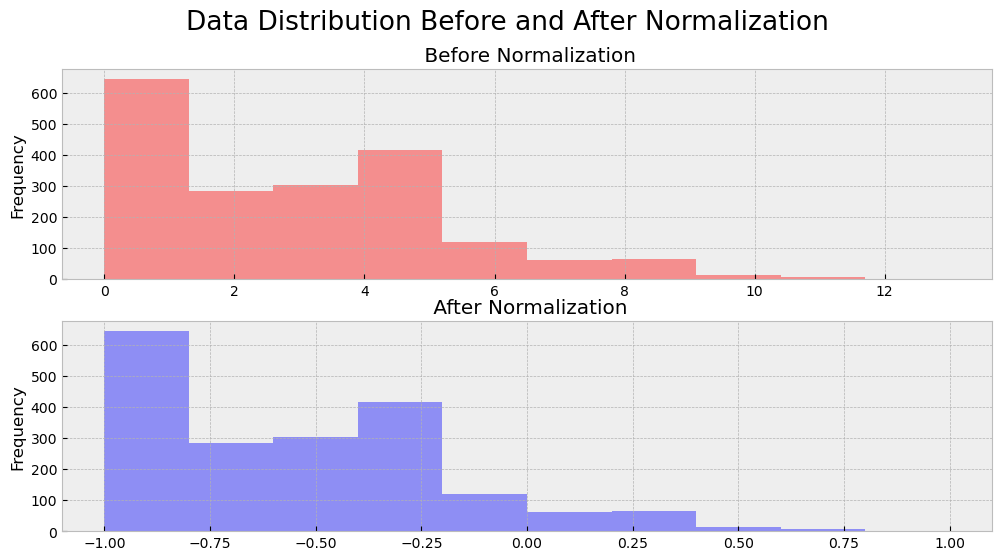

In [29]:
fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='red') 
pd.DataFrame(train_data_normalized).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'blue')
   

In [30]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [31]:
seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1884, 28, 1)
(1884, 1)


In [32]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [33]:
print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1262, 28, 1])
train label shape is: torch.Size([1262, 1])
test shape is: torch.Size([622, 28, 1])
test label shape is: torch.Size([622, 1])


In [34]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [35]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [36]:
num_epochs = 600
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))


Epoch: 0, loss: 0.38219 valid loss:  0.40848 
Epoch: 50, loss: 0.15671 valid loss:  0.10296 
Epoch: 100, loss: 0.16117 valid loss:  0.10227 
Epoch: 150, loss: 0.16322 valid loss:  0.08918 
Epoch: 200, loss: 0.15446 valid loss:  0.09873 
Epoch: 250, loss: 0.15904 valid loss:  0.10493 
Epoch: 300, loss: 0.14700 valid loss:  0.09117 
Epoch: 350, loss: 0.15580 valid loss:  0.08737 
Epoch: 400, loss: 0.16203 valid loss:  0.09612 
Epoch: 450, loss: 0.14620 valid loss:  0.09720 
Epoch: 500, loss: 0.14900 valid loss:  0.08923 
Epoch: 550, loss: 0.15320 valid loss:  0.09882 


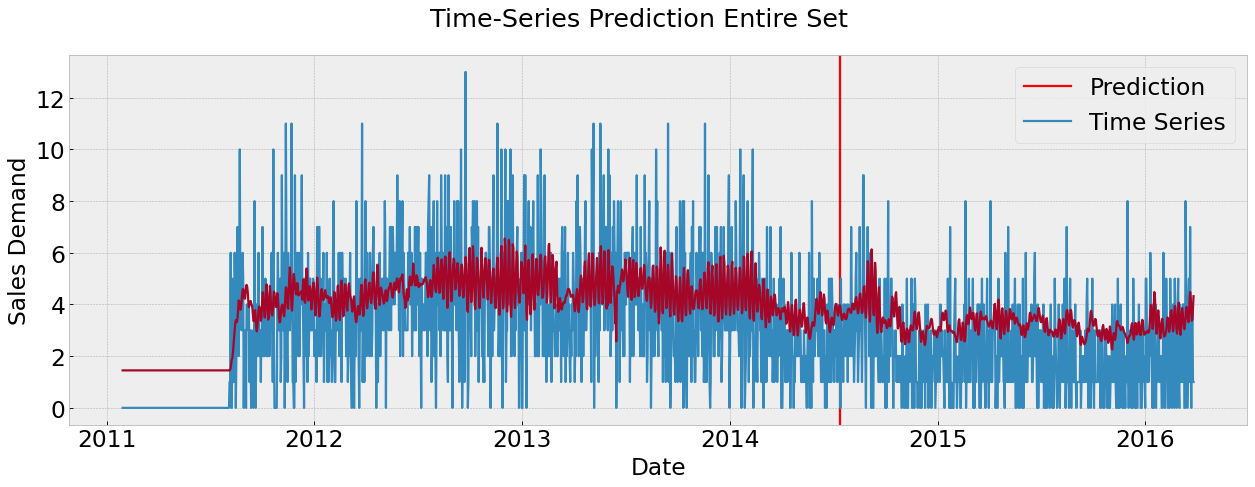

In [37]:
lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

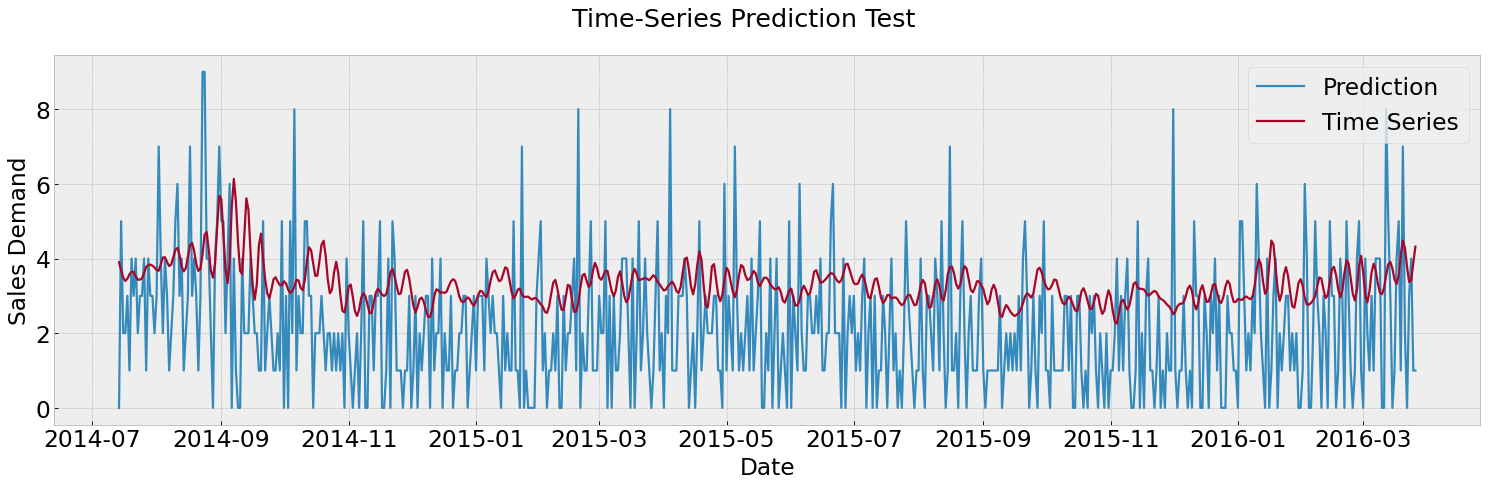

In [38]:
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [39]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

2.0621872

In [40]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
       
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out
    
   
        
       
        

In [41]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [42]:
num_epochs = 700
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 2

num_classes = 1

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    scheduler.step(loss)
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 0.44992 valid loss:  0.07265 
Epoch: 50, loss: 0.10332 valid loss:  0.07179 
Epoch: 100, loss: 0.09873 valid loss:  0.06941 
Epoch: 150, loss: 0.09464 valid loss:  0.07233 
Epoch: 200, loss: 0.09337 valid loss:  0.07290 
Epoch: 250, loss: 0.09244 valid loss:  0.07401 
Epoch: 300, loss: 0.09134 valid loss:  0.07491 
Epoch: 350, loss: 0.09108 valid loss:  0.07519 
Epoch: 400, loss: 0.09093 valid loss:  0.07563 
Epoch: 450, loss: 0.09119 valid loss:  0.07588 
Epoch: 500, loss: 0.09081 valid loss:  0.07594 
Epoch: 550, loss: 0.09009 valid loss:  0.07607 
Epoch: 600, loss: 0.09109 valid loss:  0.07609 
Epoch: 650, loss: 0.09056 valid loss:  0.07612 


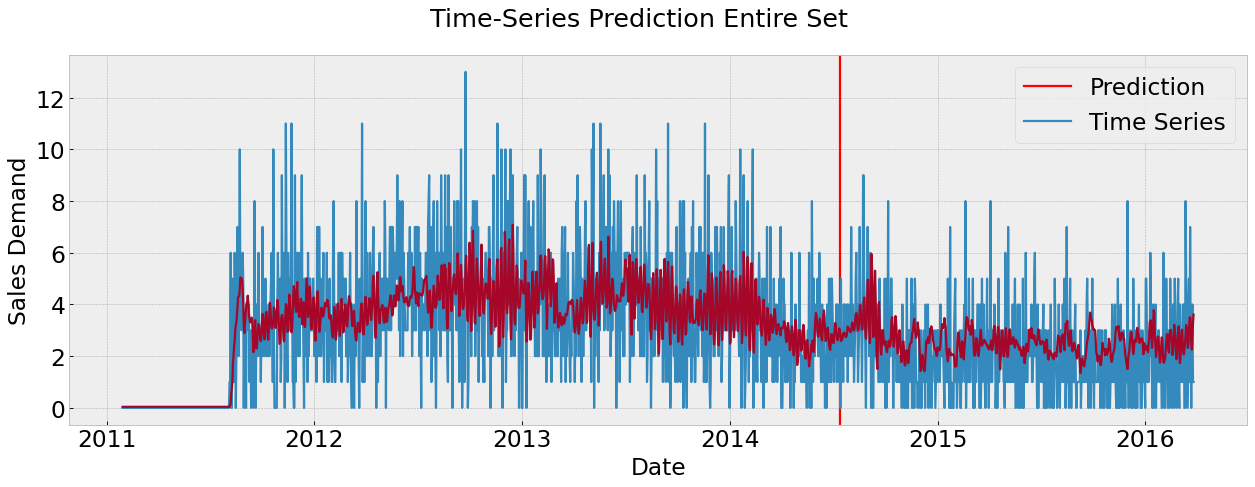

In [43]:
lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


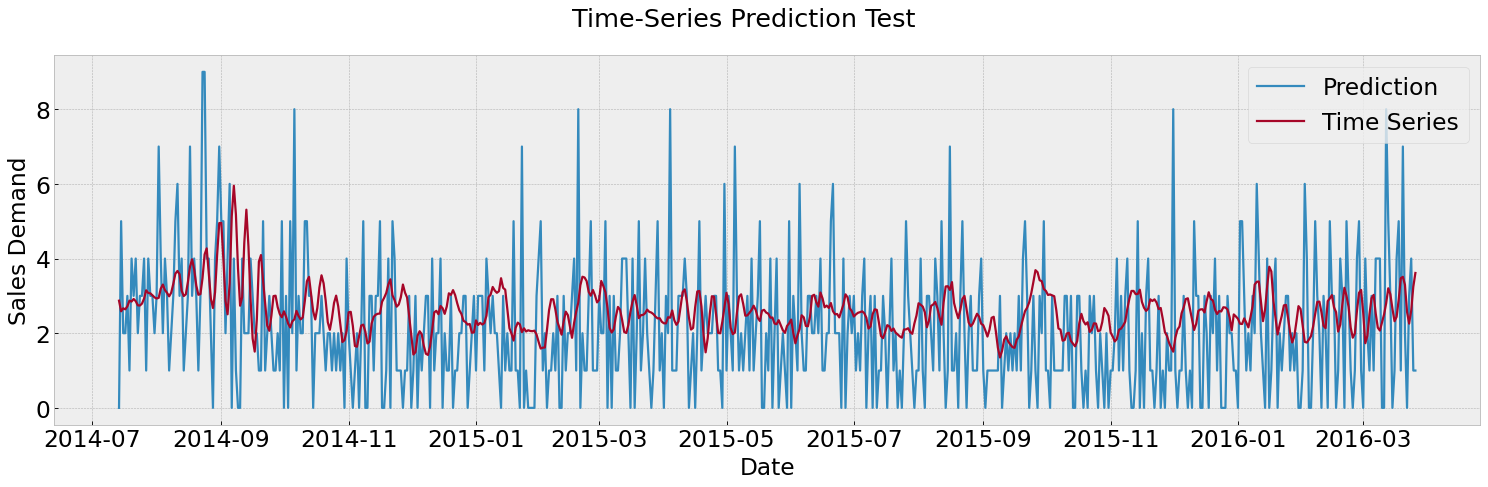

In [44]:
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [45]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

1.7931162

In [46]:
DF = TS_selected
colnames = DF.columns
DF = DF.rename(columns={colnames[0]:'sales'})
DF.tail()

,sales
2016-04-20,3
2016-04-21,4
2016-04-22,1
2016-04-23,1
2016-04-24,4


In [47]:
start_time = time.time()
for i in (1,7,14,28,365):
    print('Shifting:', i)
    DF['lag_'+str(i)] = DF['sales'].transform(lambda x: x.shift(i))
print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))


Shifting: 1
Shifting: 7
Shifting: 14
Shifting: 28
Shifting: 365
0.00 min: Time for bulk shift


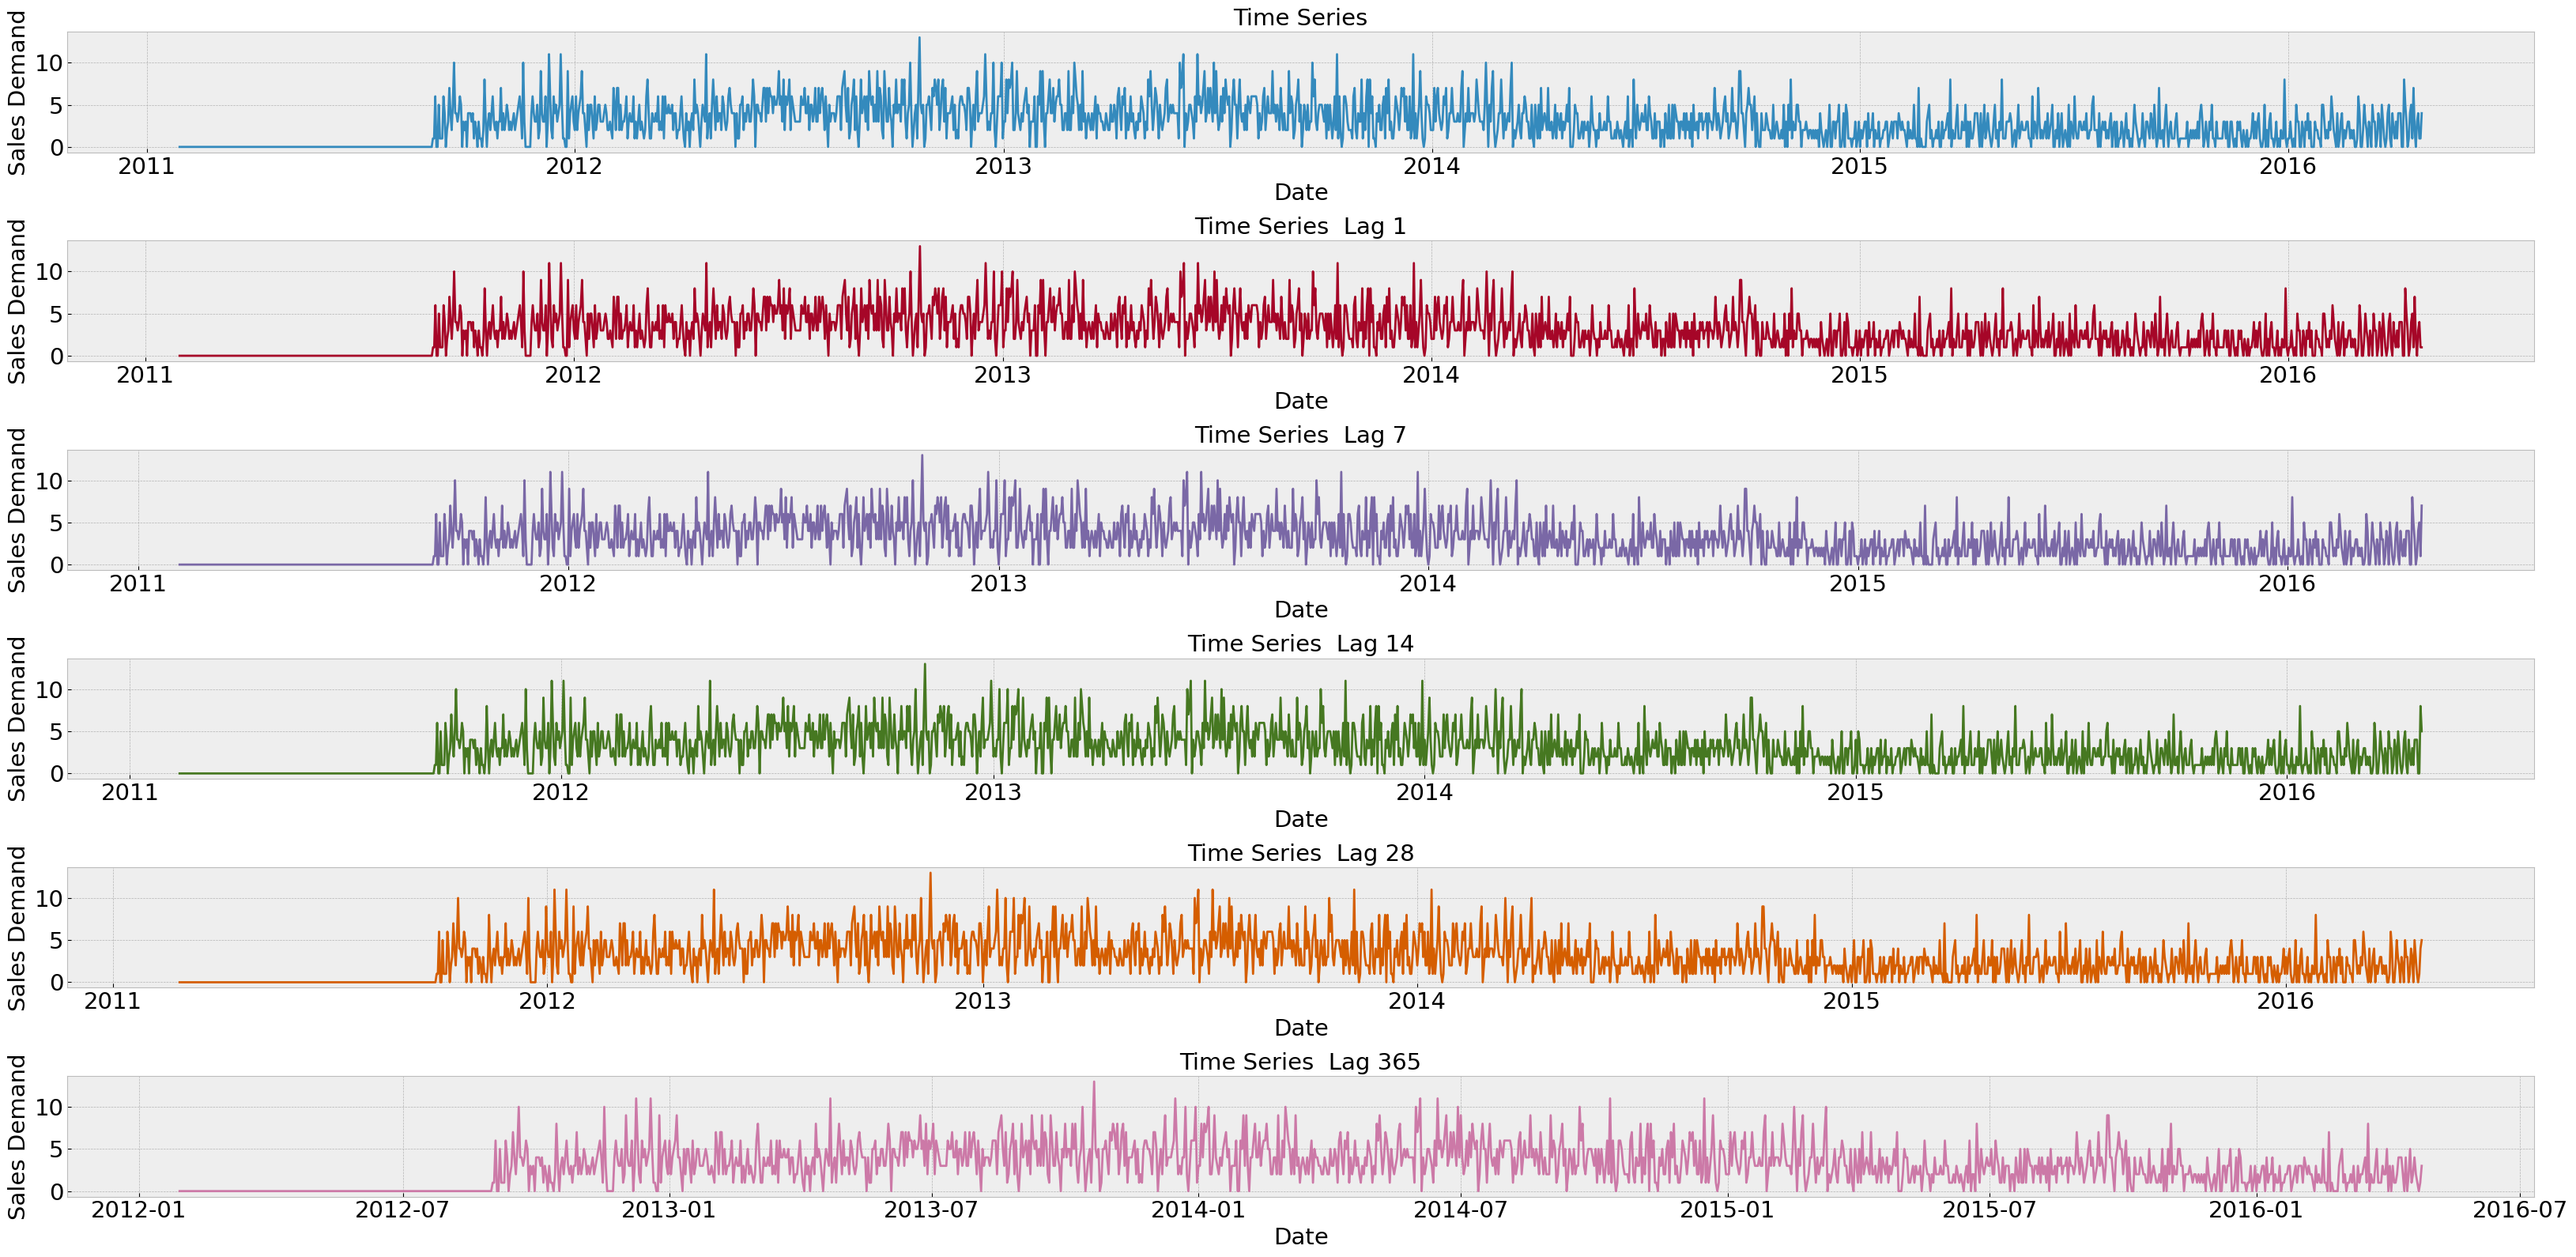

In [48]:
 DF = DF.set_index([dates_list])
Product = "Time Series"

fig, axs = plt.subplots(6, 1, figsize=(33, 16))
axs = axs.flatten()
ax_idx = 0

for i in (0,1,7,14,28,365):
    if i == 0:
        ax = DF['sales'].plot(fontsize = 21,
                     legend =False,
                     color=next(color_cycle),
                     ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand",fontsize = 21)
        ax.set_xlabel("Date",fontsize = 21)
        ax.set_title(fontsize = 21,label = Product)

        ax_idx += 1
    else : 
        ax = DF[f'lag_{i}'].plot(fontsize = 21,
                     legend =False,
                     color=next(color_cycle),
                     ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand",fontsize = 21)
        ax.set_xlabel("Date",fontsize = 21)
        ax.set_title(fontsize = 21,label = Product+f'  Lag {i}')

        ax_idx += 1
    
   
   
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )

plt.tight_layout()
plt.show()


In [49]:
for i in [7,14,28,60,180,365]:
    print('Rolling period:', i)
    DF['rolling_mean_'+str(i)] = DF['sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    DF['rolling_std_'+str(i)]  = DF['sales'].transform(lambda x: x.shift(28).rolling(i).std())


print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))
DF.head()

Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 60
Rolling period: 180
Rolling period: 365
0.02 min: Time for loop


,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-30,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-31,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-01,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-02,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
DF = DF.replace('nan', np.nan).fillna(0)
DF.head()

,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-31,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-02,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
DF_normlized = DF.copy(deep=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(DF) 
y_scaler.fit_transform(DF['sales'].values.reshape(-1, 1))
DF_normlized.iloc[:,:] =  scaled_data
DF_normlized.head()

,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-01-30,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-01-31,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-01,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-02,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [52]:
DF_normlized = DF_normlized.reset_index()
DF_normlized = DF_normlized.rename(columns={'index':'date'})
DF_normlized.head()
DF_normlized['date'] = DF_normlized['date'].apply(lambda x: x.strftime("%Y-%m-%d"))
DF_normlized = DF_normlized.merge(calendar_df[['date','weekday']],on='date')
DF_normlized

,date,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365,weekday
0,2011-01-29,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,Saturday
1,2011-01-30,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,Sunday
2,2011-01-31,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,Monday
3,2011-02-01,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,Tuesday
4,2011-02-02,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,-0.538462,-1.000000,-0.846154,-0.384615,-0.846154,-0.692308,-0.291667,-0.205281,-0.204819,-0.069629,-0.248408,0.174012,-0.148515,0.189775,-0.242353,0.213725,-0.140616,0.308479,Wednesday
1909,2016-04-21,-0.384615,-0.538462,-0.384615,-1.000000,-1.000000,-0.846154,-0.333333,-0.133644,-0.277108,-0.017697,-0.261146,0.193974,-0.168317,0.203008,-0.244706,0.217284,-0.146651,0.304557,Thursday
1910,2016-04-22,-0.846154,-0.384615,-0.230769,-1.000000,-0.846154,-1.000000,-0.458333,-0.182570,-0.301205,-0.004147,-0.273885,0.200850,-0.174917,0.207153,-0.249412,0.216056,-0.146651,0.304557,Friday
1911,2016-04-23,-0.846154,-0.846154,-0.846154,0.230769,-0.384615,-0.846154,-0.416667,-0.123143,-0.204819,-0.023331,-0.222930,0.195530,-0.161716,0.219679,-0.249412,0.216056,-0.143030,0.306923,Saturday


In [53]:
DF_normlized['wd1'] =0
DF_normlized['wd2'] =0
DF_normlized['wd3'] =0
DF_normlized['wd4'] =0

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Sunday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Sunday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Sunday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Sunday']= 0.4 ,-0.3 ,0.6,0.1

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Monday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Monday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Monday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Monday']= 0.2 ,0.2 ,0.5,-0.3

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Tuesday'] ,DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Tuesday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Tuesday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Tuesday']= 0.1,-1.0,1.3,0.9

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Wednesday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Wednesday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Wednesday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Wednesday']= -0.6,0.5,1.2,0.7

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Thursday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Thursday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Thursday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Thursday']= 0.9,0.2,-0.1,0.6

DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Friday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Friday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Friday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Friday']= 0.4,1.1,0.3,-1.5


DF_normlized.loc[:,'wd1'][DF_normlized['weekday'] =='Saturday'] , DF_normlized.loc[:,'wd2'][DF_normlized['weekday'] =='Saturday'],\
DF_normlized.loc[:,'wd3'][DF_normlized['weekday'] =='Saturday'] , DF_normlized.loc[:,'wd4'][DF_normlized['weekday'] =='Saturday']= 0.3,-0.2,0.6,0.0


<AxesSubplot:title={'center':' After Normalization'}, ylabel='Frequency'>

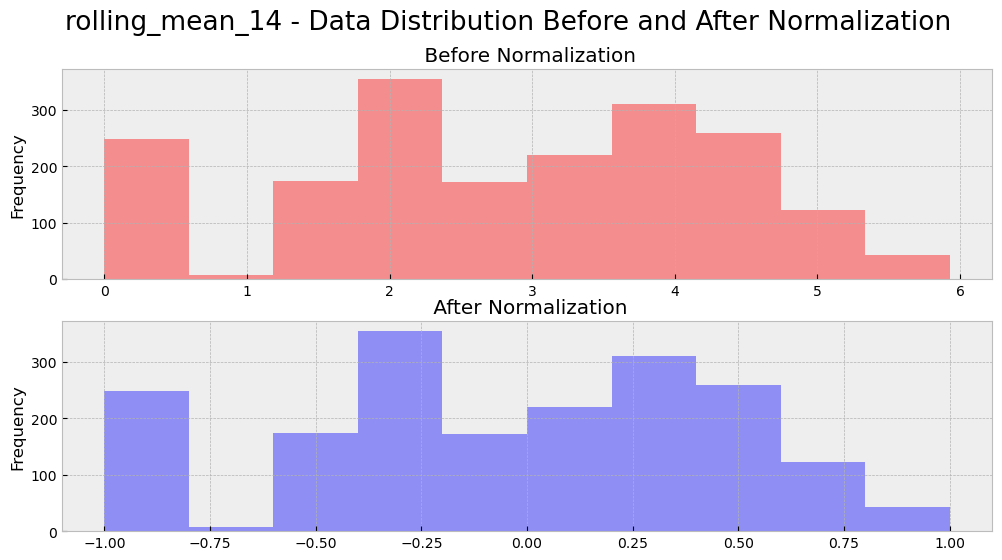

In [54]:
fig, axs = plt.subplots(2)
 
fig.suptitle('rolling_mean_14 - Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(DF['rolling_mean_14']).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='red') 
pd.DataFrame(DF_normlized['rolling_mean_14']).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'blue')

In [55]:
def sliding_windows_mutli_features(data, seq_length):
    x = []
    y = []

    for i in range((data.shape[0])-seq_length-1):
        _x = data[i:(i+seq_length),:] ## 16 columns for features  
        _y = data[i+seq_length,0] ## column 0 contains the labbel
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y).reshape(-1,1)

In [56]:
data_with_features = DF_normlized[["sales","lag_7","lag_1","lag_28","lag_365","rolling_mean_7",\
"rolling_std_7","rolling_mean_14","rolling_std_14","rolling_mean_28","rolling_std_28","rolling_mean_60","rolling_std_60",'lag_28','wd1','wd2','wd3','wd4']].to_numpy()             

data_with_features.shape

(1913, 18)

In [57]:
x , y = sliding_windows_mutli_features(data_with_features,seq_length=28)
print("X_data shape is",x.shape)
print("y_data shape is",y.shape)

X_data shape is (1884, 28, 18)
y_data shape is (1884, 1)


In [58]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1262, 28, 18])
train label shape is: torch.Size([1262, 1])
test shape is: torch.Size([622, 28, 18])
test label shape is: torch.Size([622, 1])


In [59]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.2)
       
        
        
        self.fc1 = nn.Linear(hidden_size,256)
        self.bn1 = nn.BatchNorm1d(256,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 128)
            
        self.bn2 = nn.BatchNorm1d(128,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dp2 = nn.Dropout(0.2)
        self.fc3= nn.Linear(128, 1)
        self.relu = nn.ReLU()
       
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        
        x0 = self.fc1(final_state)
        x0 = self.bn1(x0)
        x0 = self.dp1(x0)
        x0 = self.relu(x0)
        
        x0 = self.fc2(x0)
        x0 = self.bn2(x0)
        x0 = self.dp2(x0)
        
        x0 = self.relu(x0)
        
        out = self.fc3(x0)
        return out
    
   

In [60]:
num_epochs = 500
learning_rate = 1e-3
input_size = 18
hidden_size = 512
num_layers = 4
num_classes = 1

best_val_loss = 100

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device) 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=50, factor =0.5 ,min_lr=1e-7, eps=1e-08)

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    #scheduler.step()
    
    if vall_loss.cpu().item() < best_val_loss:
         torch.save(lstm.state_dict(), 'best_model.pt')
         print("saved best model epoch:",epoch,"val loss is:",vall_loss.cpu().item())
         best_val_loss = vall_loss.cpu().item()
        
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

saved best model epoch: 0 val loss is: 0.5951629877090454
Epoch: 0, loss: 0.44861 valid loss:  0.59516 
saved best model epoch: 1 val loss is: 0.5859713554382324
saved best model epoch: 2 val loss is: 0.5767928957939148
saved best model epoch: 3 val loss is: 0.567698061466217
saved best model epoch: 4 val loss is: 0.5581762790679932
saved best model epoch: 5 val loss is: 0.5483726263046265
saved best model epoch: 6 val loss is: 0.538995087146759
saved best model epoch: 7 val loss is: 0.5322296023368835
saved best model epoch: 8 val loss is: 0.5242361426353455
saved best model epoch: 9 val loss is: 0.5144127011299133
saved best model epoch: 10 val loss is: 0.5039688944816589
saved best model epoch: 11 val loss is: 0.48620468378067017
saved best model epoch: 12 val loss is: 0.46649155020713806
saved best model epoch: 13 val loss is: 0.45159125328063965
saved best model epoch: 14 val loss is: 0.4387820363044739
saved best model epoch: 15 val loss is: 0.43071281909942627
saved best model e

KeyboardInterrupt: 

(1884, 1)
(1884, 1)


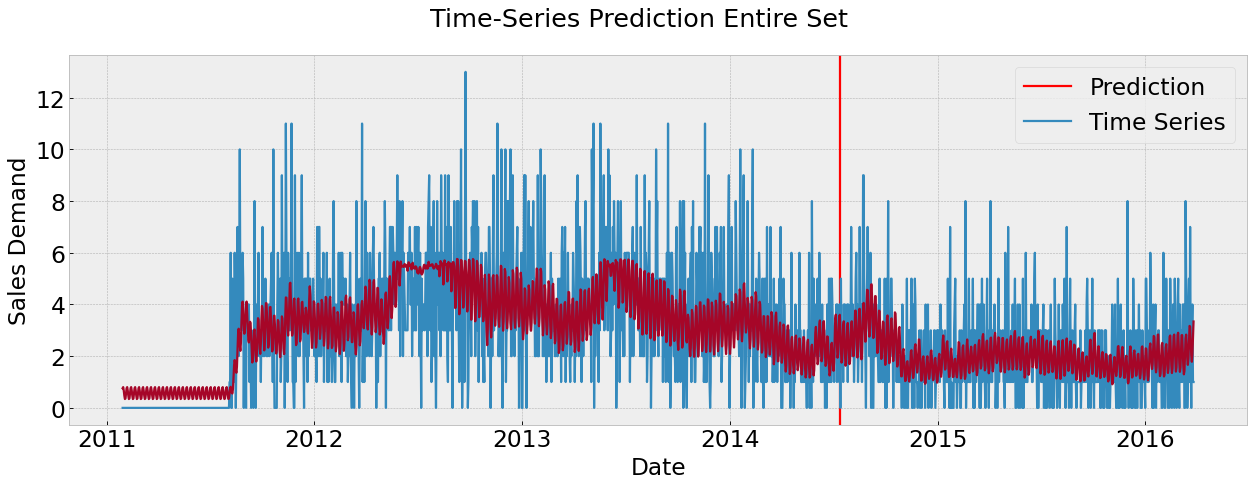

In [61]:
######Prediction###############
lstm.load_state_dict(torch.load('best_model.pt'))

lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()
print(data_predict.shape)
print(dataY_plot.shape)


## Inverse Normalize 
data_predict = y_scaler.inverse_transform(data_predict)
dataY_plot = y_scaler.inverse_transform(dataY_plot.reshape(-1, 1))

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


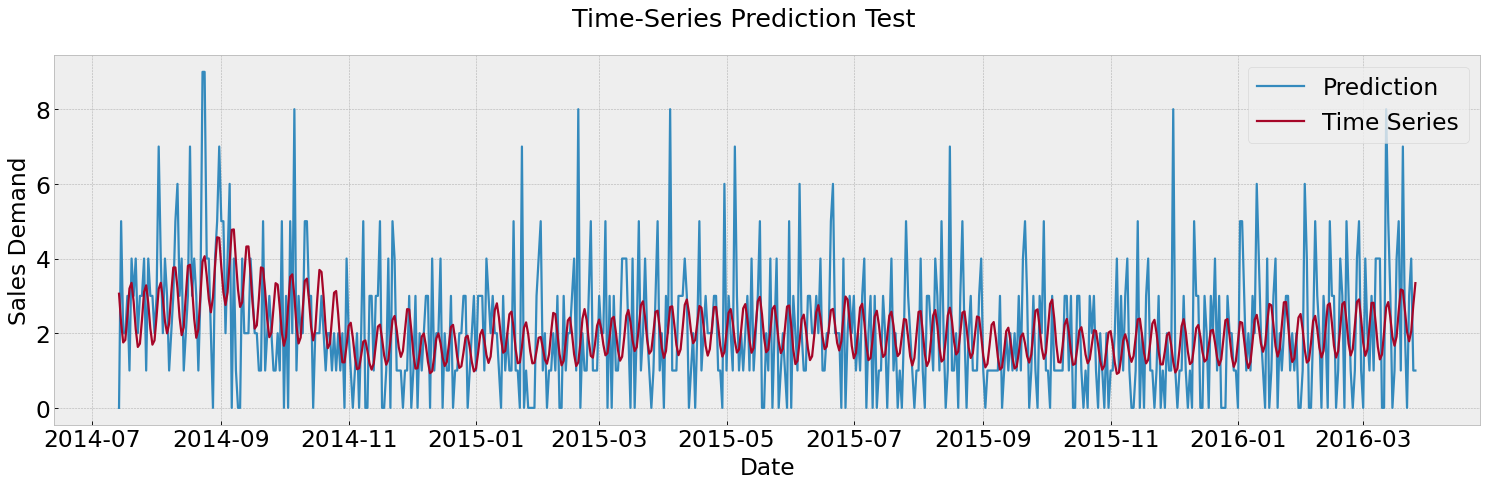

In [62]:

#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [63]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

1.6567757